In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
from PIL import Image
import os

# Path to a sample image
sample_image_path = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg'

# Open an image file
with Image.open(sample_image_path) as img:
    width, height = img.size
    print(f"Image size: {width}x{height}")

Image size: 705x569


In [4]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization ,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:
import splitfolders
splitfolders.ratio(
    "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.7,0.15, 0.15)
)

Copying files: 12446 files [02:06, 98.15 files/s] 


In [6]:
train_dir = './dataset/train'
test_dir = './dataset/test'
val_dir = './dataset/val'

train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)
val_classes = os.listdir(val_dir)

print(f"Classes found in training directory: {train_classes}")
print(f"Classes found in training directory: {test_classes}")
print(f"Classes found in validation directory: {val_classes}")


Classes found in training directory: ['Cyst', 'Stone', 'Normal', 'Tumor']
Classes found in training directory: ['Cyst', 'Stone', 'Normal', 'Tumor']
Classes found in validation directory: ['Cyst', 'Stone', 'Normal', 'Tumor']


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="reflect"
)

train_generator = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(224, 224),
    class_mode='categorical', 
    batch_size=64,
)

test_datagen = ImageDataGenerator(rescale = 1/255.0)

test_generator = test_datagen.flow_from_directory(
     './dataset/test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 64
)

val_datagen = ImageDataGenerator(rescale=1/255.0)

val_generator = val_datagen.flow_from_directory(
    './dataset/val',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
)


Found 8710 images belonging to 4 classes.
Found 1871 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.


In [28]:
# Define a function to compile and train each model with uniform settings
def compile_and_train(model, model_name, epochs=20):
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training {model_name} Model")
    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=val_generator
    )
    return history

In [9]:
# Model Architectures
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, MobileNetV2

In [10]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,           # Stop after 5 epochs with no improvement
    restore_best_weights=True
)

In [11]:
# 1. ResNet50

def build_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='selu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model

In [12]:
# 2. InceptionV3

def build_inception():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='selu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model

In [13]:
# 3. VGG16

def build_vgg():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='selu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model

In [14]:
# 4. MobileNetV2

def build_mobilenet():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='selu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model

In [15]:
# 5. LeNet

def build_lenet():
    model = Sequential([
        Conv2D(32, kernel_size=(5,5), activation='selu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(5,5), activation='selu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(120, activation='selu', kernel_regularizer=l2(0.01)),
        Dense(84, activation='selu', kernel_regularizer=l2(0.01)),
        Dense(4, activation='softmax')
    ])
    return model

In [16]:
# Instantiate and train each model
resnet_model = build_resnet()
inception_model = build_inception()
vgg_model = build_vgg()
mobilenet_model = build_mobilenet()
lenet_model = build_lenet()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
resnet_history = compile_and_train(resnet_model, "ResNet50")

Training ResNet50 Model
Epoch 1/20


I0000 00:00:1731329319.288891     116 service.cc:145] XLA service 0x7d4854003d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731329319.288951     116 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731329319.288955     116 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731329356.538500     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1731329356.585305     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/137 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7247 - loss: 8.8134   

I0000 00:00:1731329484.300802     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 20 bytes spill stores, 20 bytes spill loads



137/137 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.7425 - loss: 8.7247 - val_accuracy: 0.1866 - val_loss: 8.4681
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1866 - val_loss: 8.4681
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 131s 911ms/step - accuracy: 0.9709 - loss: 6.8681 - val_accuracy: 0.1651 - val_loss: 7.6674
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1651 - val_loss: 7.6674
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 131s 906ms/step - accuracy: 0.9819 - loss: 5.4938 - val_accuracy: 0.1115 - val_loss: 8.0153
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1115 - val_loss: 8.0153
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 130s 901ms/step - accuracy: 0.9880 - loss: 4.2442 - val_accuracy: 0.1105 - val_loss: 8.3144
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.0000e+00

In [18]:
inception_history = compile_and_train(inception_model, "InceptionV3")

Training InceptionV3 Model
Epoch 1/20
 39/137 ━━━━━━━━━━━━━━━━━━━━ 1:22 841ms/step - accuracy: 0.5331 - loss: 9.2839

I0000 00:00:1731330918.776146     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 72 bytes spill stores, 72 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 16 bytes spill stores, 16 bytes spill loads



137/137 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.6851 - loss: 8.6624 - val_accuracy: 0.8697 - val_loss: 7.1297
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8697 - val_loss: 7.1297
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 163s 895ms/step - accuracy: 0.9527 - loss: 6.4503 - val_accuracy: 0.9684 - val_loss: 5.2310
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9684 - val_loss: 5.2310
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 128s 888ms/step - accuracy: 0.9791 - loss: 4.8439 - val_accuracy: 0.9571 - val_loss: 3.8828
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9571 - val_loss: 3.8828
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 129s 893ms/step - accuracy: 0.9842 - loss: 3.5210 - val_accuracy: 0.9571 - val_loss: 2.7933
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.0000e+00

In [19]:
vgg_history = compile_and_train(vgg_model, "VGG16")

Training VGG16 Model
Epoch 1/20
 31/137 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.3195 - loss: 11.1246   

I0000 00:00:1731332399.366976     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 208 bytes spill stores, 208 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 20 bytes spill stores, 20 bytes spill loads



137/137 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.3669 - loss: 8.7987 - val_accuracy: 0.4080 - val_loss: 3.6314
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4080 - val_loss: 3.6314
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 133s 919ms/step - accuracy: 0.4079 - loss: 3.1152 - val_accuracy: 0.4080 - val_loss: 2.1451
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4080 - val_loss: 2.1451
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 133s 920ms/step - accuracy: 0.4208 - loss: 2.0108 - val_accuracy: 0.6515 - val_loss: 1.4603
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6515 - val_loss: 1.4603
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 132s 916ms/step - accuracy: 0.6485 - loss: 1.3215 - val_accuracy: 0.7282 - val_loss: 0.9905
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0000e+00

In [20]:
mobilenet_history = compile_and_train(mobilenet_model, "MobileNetV2")

Training MobileNetV2 Model
Epoch 1/20
 34/137 ━━━━━━━━━━━━━━━━━━━━ 2:25 1s/step - accuracy: 0.5279 - loss: 8.6062   

I0000 00:00:1731333882.819078     117 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_225', 248 bytes spill stores, 248 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_224', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_and_reduce_fusion', 284 bytes spill stores, 292 bytes spill loads



137/137 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6880 - loss: 7.9674 - val_accuracy: 0.6188 - val_loss: 8.0220
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6188 - val_loss: 8.0220
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 140s 872ms/step - accuracy: 0.9466 - loss: 6.2979 - val_accuracy: 0.6172 - val_loss: 7.1002
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6172 - val_loss: 7.1002
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 874ms/step - accuracy: 0.9635 - loss: 5.1940 - val_accuracy: 0.5946 - val_loss: 6.1319
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5946 - val_loss: 6.1319
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 878ms/step - accuracy: 0.9771 - loss: 4.1902 - val_accuracy: 0.5748 - val_loss: 5.2602
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.0000e+00

In [29]:
lenet_history = compile_and_train(lenet_model, "LeNet")

Training LeNet Model
Epoch 1/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 124s 846ms/step - accuracy: 0.6550 - loss: 1.6218 - val_accuracy: 0.6847 - val_loss: 1.5609
Epoch 2/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6847 - val_loss: 1.5609
Epoch 3/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 121s 842ms/step - accuracy: 0.6820 - loss: 1.5491 - val_accuracy: 0.6804 - val_loss: 1.5020
Epoch 4/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6804 - val_loss: 1.5020
Epoch 5/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 121s 843ms/step - accuracy: 0.6798 - loss: 1.5299 - val_accuracy: 0.6976 - val_loss: 1.4857
Epoch 6/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6976 - val_loss: 1.4857
Epoch 7/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 121s 847ms/step - accuracy: 0.6866 - loss: 1.5032 - val_accuracy: 0.7072 - val_loss: 1.4408
Epoch 8/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 

In [22]:
# Dictionary to store test accuracies and losses
test_accuracies = {}
test_losses = {}

# Evaluate each model on the test data
print("Evaluating ResNet50 Model...")
test_loss, test_accuracy = resnet_model.evaluate(test_generator)
test_accuracies["ResNet50"] = test_accuracy
test_losses["ResNet50"] = test_loss
print(f"ResNet50 - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

print("Evaluating InceptionV3 Model...")
test_loss, test_accuracy = inception_model.evaluate(test_generator)
test_accuracies["InceptionV3"] = test_accuracy
test_losses["InceptionV3"] = test_loss
print(f"InceptionV3 - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

print("Evaluating VGG16 Model...")
test_loss, test_accuracy = vgg_model.evaluate(test_generator)
test_accuracies["VGG16"] = test_accuracy
test_losses["VGG16"] = test_loss
print(f"VGG16 - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

print("Evaluating MobileNetV2 Model...")
test_loss, test_accuracy = mobilenet_model.evaluate(test_generator)
test_accuracies["MobileNetV2"] = test_accuracy
test_losses["MobileNetV2"] = test_loss
print(f"MobileNetV2 - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

print("Evaluating LeNet Model...")
test_loss, test_accuracy = lenet_model.evaluate(test_generator)
test_accuracies["LeNet"] = test_accuracy
test_losses["LeNet"] = test_loss
print(f"LeNet - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Display all results
print("\nComparative Analysis of Model Performance:")
for model_name in test_accuracies.keys():
    print(f"{model_name} - Test Accuracy: {test_accuracies[model_name]:.4f}, Test Loss: {test_losses[model_name]:.4f}")


Evaluating ResNet50 Model...
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 931ms/step - accuracy: 0.9937 - loss: 0.5501
ResNet50 - Test Accuracy: 0.9898, Test Loss: 0.5577
Evaluating InceptionV3 Model...
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9910 - loss: 0.3170 
InceptionV3 - Test Accuracy: 0.9904, Test Loss: 0.3160
Evaluating VGG16 Model...
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9832 - loss: 0.0972 
VGG16 - Test Accuracy: 0.9802, Test Loss: 0.1062
Evaluating MobileNetV2 Model...
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 940ms/step - accuracy: 0.5886 - loss: 2.9508
MobileNetV2 - Test Accuracy: 0.5901, Test Loss: 2.9586
Evaluating LeNet Model...
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 858ms/step - accuracy: 0.6669 - loss: 1.5942
LeNet - Test Accuracy: 0.6745, Test Loss: 1.5843

Comparative Analysis of Model Performance:
ResNet50 - Test Accuracy: 0.9898, Test Loss: 0.5577
InceptionV3 - Test Accuracy: 0.9904, Test Loss: 0.3160
VGG16 - Test Accuracy: 0.9802, Test Loss: 0.1062
MobileNetV2 - Test 

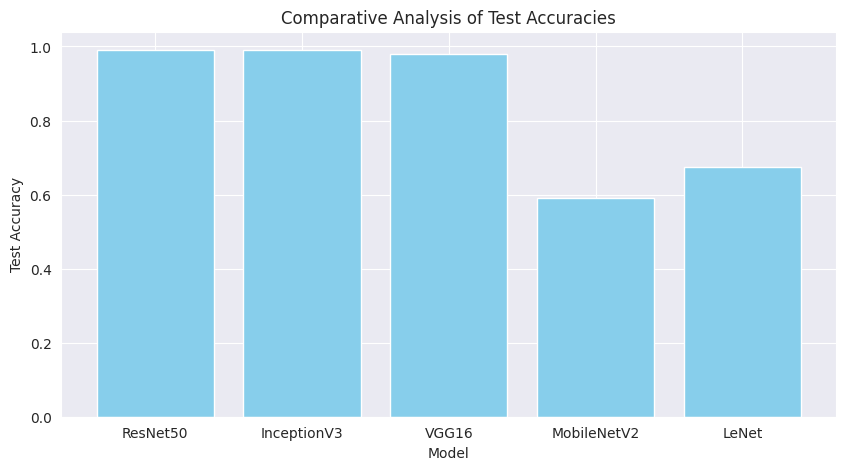

In [23]:
# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.title("Comparative Analysis of Test Accuracies")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.show()

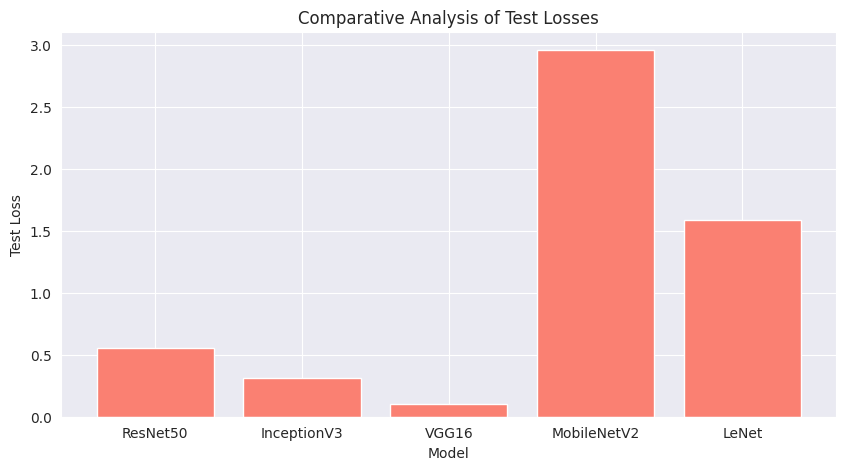

In [24]:
# Plot Test Loss
plt.figure(figsize=(10, 5))
plt.bar(test_losses.keys(), test_losses.values(), color='salmon')
plt.title("Comparative Analysis of Test Losses")
plt.xlabel("Model")
plt.ylabel("Test Loss")
plt.show()

Confusion Matrix for ResNet50:
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 885ms/step


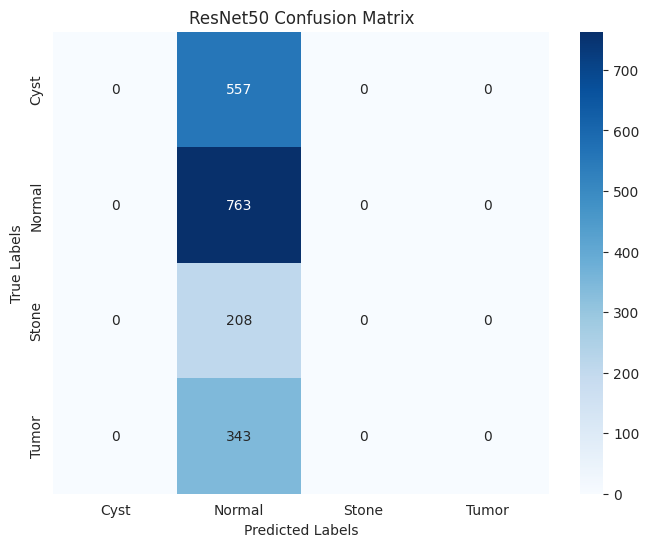

Confusion Matrix for InceptionV3:
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 945ms/step


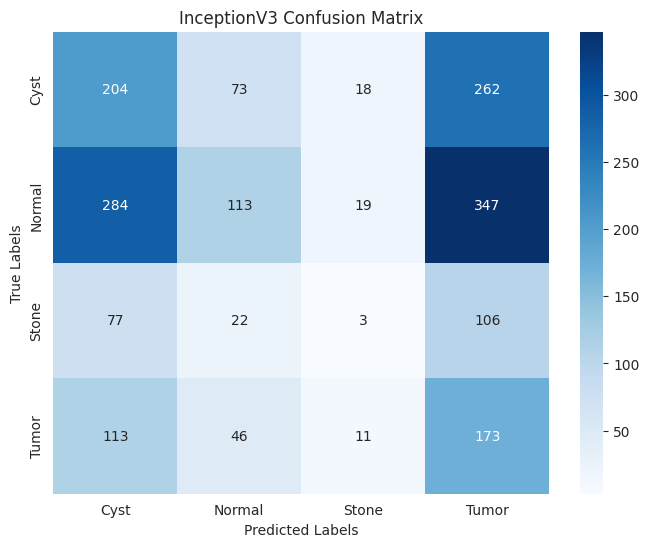

Confusion Matrix for VGG16:
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 807ms/step


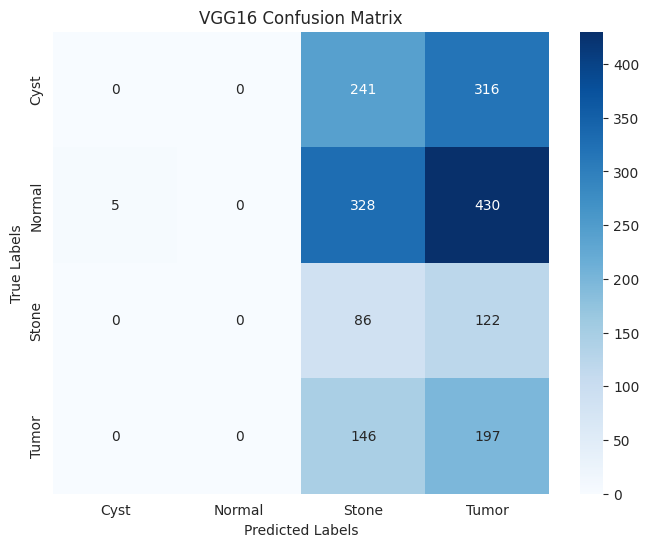

Confusion Matrix for MobileNetV2:
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 874ms/step


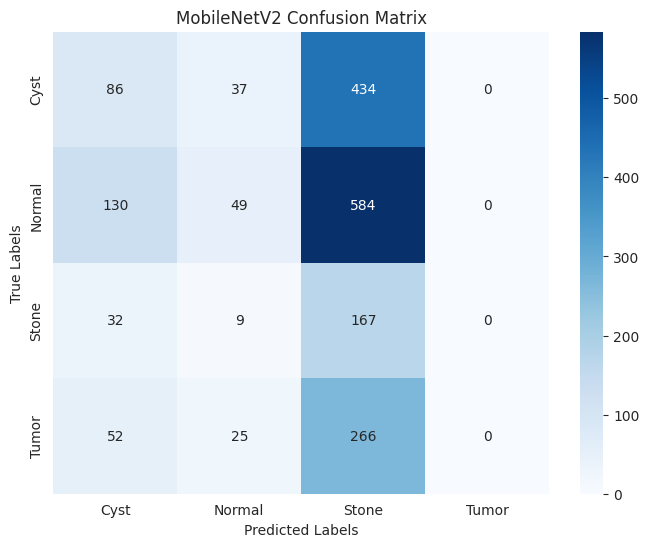

Confusion Matrix for LeNet:
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 810ms/step


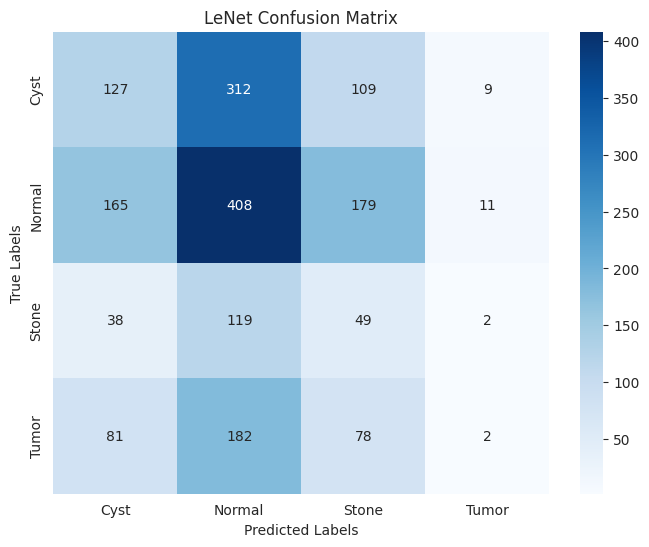

In [25]:
# Display confusion matrices for each model

models = {
    "ResNet50": build_resnet(),
    "InceptionV3": build_inception(),
    "VGG16": build_vgg(),
    "MobileNetV2": build_mobilenet(),
    "LeNet": build_lenet()
}
class_labels = list(test_generator.class_indices.keys())

for model_name, model in models.items():
    print(f"Confusion Matrix for {model_name}:")
    predictions = model.predict(test_generator)
    y_pred = predictions.argmax(axis=1)  # Get the predicted class indices
    y_true = test_generator.classes  # True labels from the generator

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [26]:
# Generate and print classification reports for each model
for model_name, model in models.items():
    print(f"Classification Report for {model_name}:")
    predictions = model.predict(test_generator)  # Make sure `test_generator` is defined
    y_pred = predictions.argmax(axis=1)  # Get the predicted class indices
    y_true = test_generator.classes  # True labels from the generator
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print(report)

Classification Report for ResNet50:
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 811ms/step
              precision    recall  f1-score   support

        Cyst       0.00      0.00      0.00       557
      Normal       0.41      1.00      0.58       763
       Stone       0.00      0.00      0.00       208
       Tumor       0.00      0.00      0.00       343

    accuracy                           0.41      1871
   macro avg       0.10      0.25      0.14      1871
weighted avg       0.17      0.41      0.24      1871

Classification Report for InceptionV3:
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 810ms/step
              precision    recall  f1-score   support

        Cyst       0.31      0.39      0.35       557
      Normal       0.42      0.12      0.19       763
       Stone       0.07      0.01      0.02       208
       Tumor       0.18      0.49      0.27       343

    accuracy                           0.26      1871
   macro avg       0.25      0.25      0.21      1871
weighted avg       0.31   

In [27]:
# Step 1: Collect training and validation metrics
train_accuracies = {}
val_accuracies = {}
train_losses = {}
val_losses = {}

histories = {
    "ResNet50": resnet_history,
    "InceptionV3": inception_history,
    "VGG16": vgg_history,
    "MobileNetV2": mobilenet_history,
    "LeNet": lenet_history
}

for model_name, history in histories.items():
    train_accuracies[model_name] = history.history['accuracy'][-2]  
    val_accuracies[model_name] = history.history['val_accuracy'][-1] 
    train_losses[model_name] = history.history['loss'][-2] 
    val_losses[model_name] = history.history['val_loss'][-1] 

# Step 2: Create a summary DataFrame
summary_df = pd.DataFrame({
    'Model': list(train_accuracies.keys()),
    'Train Accuracy': list(train_accuracies.values()),
    'Validation Accuracy': list(val_accuracies.values()),
    'Test Accuracy': list(test_accuracies.values()),
    'Train Loss': list(train_losses.values()),
    'Validation Loss': list(val_losses.values()),
    'Test Loss': list(test_losses.values()),
})

# Display the summary table
print(summary_df)


         Model  Train Accuracy  Validation Accuracy  Test Accuracy  \
0     ResNet50        0.995293             0.989276       0.989845   
1  InceptionV3        0.995522             0.971046       0.990379   
2        VGG16        0.973249             0.994638       0.980224   
3  MobileNetV2        0.991734             0.529759       0.590059   
4        LeNet        0.672331             0.639678       0.674506   

   Train Loss  Validation Loss  Test Loss  
0    0.643413         0.562010   0.557741  
1    0.374996         0.377462   0.315951  
2    0.140778         0.072538   0.106156  
3    0.799361         3.686381   2.958627  
4    1.599186         1.618164   1.584315  


In [3]:
import pandas as pd

# Data for the experimental results
data = {
    'Run No.': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    'Model': ['ResNet50', 'InceptionV3', 'VGG16', 'ResNet50', 'InceptionV3', 'VGG16', 
              'ResNet50', 'InceptionV3', 'VGG16', 'ResNet50', 'InceptionV3', 'VGG16'],
    'Train Accuracy': [0.995063, 0.991045, 0.978990, 0.995752, 0.994719, 0.984730, 
                       0.994948, 0.995408, 0.990126, 0.993111, 0.991848, 0.983812],
    'Validation Accuracy': [0.978552, 0.998928, 0.991957, 0.991957, 0.994638, 0.973190, 
                            0.883110, 0.997855, 0.990885, 0.833244, 0.997855, 0.987668],
    'Test Accuracy': [0.983966, 0.994655, 0.987173, 0.982897, 0.984500, 0.971673, 
                      0.782469, 0.998397, 0.994121, 0.932656, 0.997328, 0.976483],
    'Train Loss': [0.014798, 0.023931, 0.073465, 0.013533, 0.017904, 0.046544, 
                   0.016678, 0.015276, 0.037335, 0.023380, 0.024722, 0.050620],
    'Validation Loss': [0.064356, 0.004924, 0.023724, 0.054942, 0.019324, 0.084523, 
                        0.511322, 0.005456, 0.032157, 0.778793, 0.010866, 0.033016],
    'Test Loss': [0.046043, 0.019768, 0.044397, 0.052766, 0.055775, 0.078193, 
                  1.012154, 0.006970, 0.018245, 0.207848, 0.009081, 0.064054]
}

# Creating a pandas DataFrame
df = pd.DataFrame(data)

# Printing results for each run separately
for run in df['Run No.'].unique():
    print(f"Results for Run {run}:\n")
    print(df[df['Run No.'] == run].to_string(index=False))
    print("\n" + "-"*80 + "\n")

Results for Run 1:

 Run No.       Model  Train Accuracy  Validation Accuracy  Test Accuracy  Train Loss  Validation Loss  Test Loss
       1    ResNet50        0.995063             0.978552       0.983966    0.014798         0.064356   0.046043
       1 InceptionV3        0.991045             0.998928       0.994655    0.023931         0.004924   0.019768
       1       VGG16        0.978990             0.991957       0.987173    0.073465         0.023724   0.044397

--------------------------------------------------------------------------------

Results for Run 2:

 Run No.       Model  Train Accuracy  Validation Accuracy  Test Accuracy  Train Loss  Validation Loss  Test Loss
       2    ResNet50        0.995752             0.991957       0.982897    0.013533         0.054942   0.052766
       2 InceptionV3        0.994719             0.994638       0.984500    0.017904         0.019324   0.055775
       2       VGG16        0.984730             0.973190       0.971673    0.046544  

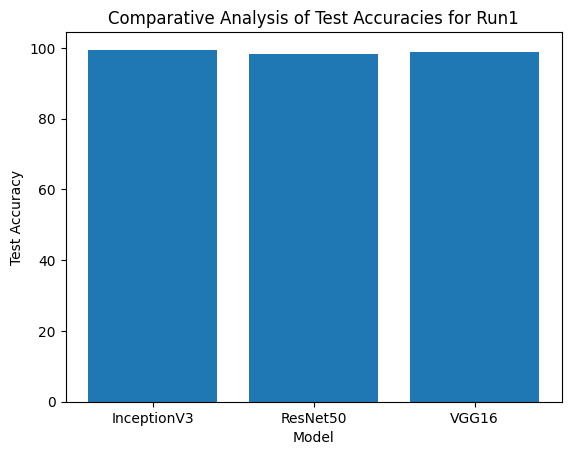

In [1]:
import matplotlib.pyplot as plt
x=['InceptionV3', 'ResNet50', 'VGG16']
y=[99.46, 98.39, 98.71]
plt.bar(x, y)
plt.title("Comparative Analysis of Test Accuracies for Run1")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.show()

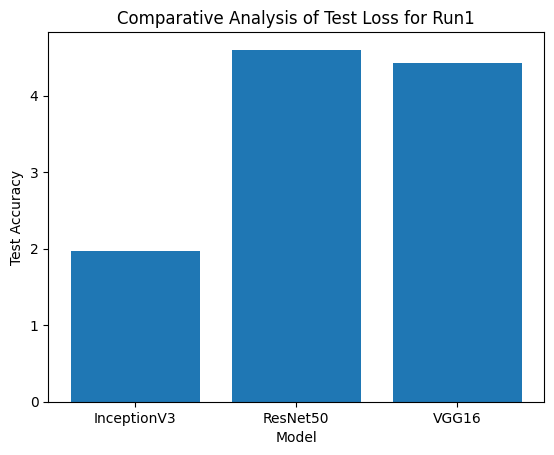

In [3]:
x=['InceptionV3', 'ResNet50', 'VGG16']
y=[ 1.97, 4.60, 4.43]
plt.bar(x, y)
plt.title("Comparative Analysis of Test Loss for Run1")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.show()